## Value Function Approximation (using a Neural Network)
This code is based on the Lecture 6 from the excelent [course on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) by David Silver.

It implements a Neural Network to learn the game Cart-pole. It works with a fixed Q-target implementation but no Experience Replay.

In [1]:
import numpy as np
import torch
import torch.nn as nn

import gym
import matplotlib.pyplot as plt
%matplotlib inline

Number of possible actions: 2
Number of possible states: Box(4,)


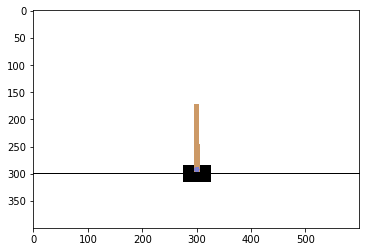

In [2]:
"""
Cart-pole environment.
https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The pendulum starts upright, and the goal is to prevent it from falling over by increasing and 
reducing the cart's velocity.

Observation: 
    Type: Box(4)
    Num	Observation                 Min         Max
    0	Cart Position             -4.8            4.8
    1	Cart Velocity             -Inf            Inf
    2	Pole Angle                 -24 deg        24 deg
    3	Pole Velocity At Tip      -Inf            Inf

Actions:
    Type: Discrete(2)
    Num	Action
    0	Push cart to the left
    1	Push cart to the right
""" 


env = gym.make("CartPole-v0").env

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class qAgent:
    def __init__(self, n_action_space, n_observation_space, epsilon, alpha, discount_factor):
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        
        self.qnetwork = nn.Sequential(
                    nn.Linear(n_observation_space[0], 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, n_action_space)
        ).to(device)
        
    def get_action_epsilon_greedy(self, state):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            state = torch.tensor(state, dtype=torch.float32, device=device)
            qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
            action = torch.argmax(qvalues).item() 
        return action
    
    def get_qvalues(self, state):
        return self.qnetwork(state)
   
    def calculate_loss(self, state, action, new_state, reward, done):
        # convert variables to tensor
        state = torch.tensor(state, dtype=torch.float32, device=device)
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)

        # predict all q-values for current state
        all_qvalues_state = self.get_qvalues(state)
       
        # select the q_value for the agent action
        qvalue_state = all_qvalues_state[action]
        
        # predict all q-values for the new state 
        all_qvalues_new_state = self.get_qvalues(new_state)
       
        # index of action that maximizes the new state q(s,a)
        argmax_new_action = torch.argmax(all_qvalues_new_state)
        # select the q-value for the new state for the action that maximises it, q'(s',amax)
        qvalue_new_state =  all_qvalues_new_state[argmax_new_action]
        
 
        # if it's a terminal state (done) the target it receives only the value of the reward
        if done:
            max_qvalue_new_state = reward
        else:
            max_qvalue_new_state = reward + self.discount_factor*qvalue_new_state

        # loss = MSE (mean squared error) between Q-network and Q-learning targets
        # the detach is a way to fix the network by not having their gradients computed
        loss = torch.mean(torch.pow(max_qvalue_new_state.detach() - qvalue_state, 2))
        
        return loss

In [5]:
# hyperparameters
epsilon = 0.5
alpha = 0.5
discount_factor = 0.99

agent = qAgent(n_action_space=env.action_space.n,
               n_observation_space=env.observation_space.shape,
               epsilon=epsilon,
               alpha=alpha,
               discount_factor=discount_factor)


In [6]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.qnetwork.parameters(), lr=learning_rate)

In [7]:
def train(trials_episode=100, solved_reward=200, n_epochs=1000):
    total_reward = []
    
    for epoch in range(n_epochs):
        
        rewards_epoch = []
        for trial in range(trials_episode):
            state = env.reset()
            done = False
            ep_rewards = 0.0
            while not done:
                action = agent.get_action_epsilon_greedy(state)

                new_state, reward, done, info = env.step(action)

                optimiser.zero_grad()
                loss = agent.calculate_loss(state, action, new_state, reward, done)
                loss.backward()
                optimiser.step()

                state = new_state
                ep_rewards += reward

            rewards_epoch.append(ep_rewards)
            total_reward.append(ep_rewards)
        
        print("Epoch={} \t epsilon={:.2f}\t reward(mean)={:.2f}".format(epoch+1, agent.epsilon, np.mean(rewards_epoch)))    
        agent.epsilon *= 0.95
        if np.mean(rewards_epoch) > solved_reward:
            break
            
    return total_reward

Epoch=1 	 epsilon=0.50	 reward(mean)=13.16
Epoch=2 	 epsilon=0.47	 reward(mean)=13.27
Epoch=3 	 epsilon=0.45	 reward(mean)=13.14
Epoch=4 	 epsilon=0.43	 reward(mean)=12.16
Epoch=5 	 epsilon=0.41	 reward(mean)=13.10
Epoch=6 	 epsilon=0.39	 reward(mean)=13.66
Epoch=7 	 epsilon=0.37	 reward(mean)=17.31
Epoch=8 	 epsilon=0.35	 reward(mean)=19.45
Epoch=9 	 epsilon=0.33	 reward(mean)=25.77
Epoch=10 	 epsilon=0.32	 reward(mean)=27.99
Epoch=11 	 epsilon=0.30	 reward(mean)=32.40
Epoch=12 	 epsilon=0.28	 reward(mean)=39.32
Epoch=13 	 epsilon=0.27	 reward(mean)=52.30
Epoch=14 	 epsilon=0.26	 reward(mean)=73.63
Epoch=15 	 epsilon=0.24	 reward(mean)=94.76
Epoch=16 	 epsilon=0.23	 reward(mean)=133.99
Epoch=17 	 epsilon=0.22	 reward(mean)=106.54
Epoch=18 	 epsilon=0.21	 reward(mean)=157.25
Epoch=19 	 epsilon=0.20	 reward(mean)=115.44
Epoch=20 	 epsilon=0.19	 reward(mean)=54.87
Epoch=21 	 epsilon=0.18	 reward(mean)=39.54
Epoch=22 	 epsilon=0.17	 reward(mean)=71.32
Epoch=23 	 epsilon=0.16	 reward(mean)

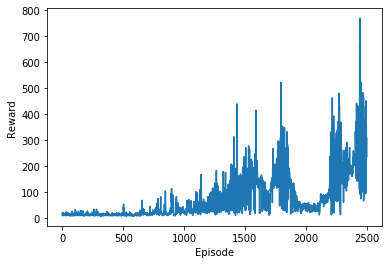

In [8]:
# CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
# https://github.com/openai/gym/wiki/Leaderboard

rewards = train(trials_episode=100, solved_reward=200, n_epochs=1000)

plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()